In [24]:
import pandas as pd 
import seaborn as sns 
import string 
from string import punctuation
import nltk
import plotly.express as px
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
review = pd.read_csv('steam_reviews.csv')
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             434891 non-null  object
 1   funny                   434891 non-null  int64 
 2   helpful                 434891 non-null  int64 
 3   hour_played             434891 non-null  int64 
 4   is_early_access_review  434891 non-null  bool  
 5   recommendation          434891 non-null  object
 6   review                  433375 non-null  object
 7   title                   434891 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 23.6+ MB


In [3]:
info = pd.read_csv('gameinfo.csv')
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [4]:
review = review .rename({'title':'name'}, axis='columns')
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             434891 non-null  object
 1   funny                   434891 non-null  int64 
 2   helpful                 434891 non-null  int64 
 3   hour_played             434891 non-null  int64 
 4   is_early_access_review  434891 non-null  bool  
 5   recommendation          434891 non-null  object
 6   review                  433375 non-null  object
 7   name                    434891 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 23.6+ MB


In [5]:
#Clean Null & Duplicated Value
review.dropna(inplace = True)
info.dropna(inplace = True)

review.drop_duplicates(inplace=True)
info.drop_duplicates(inplace=True)

In [6]:
#Merge Two Datasets (review & info)
df = pd.merge(review, info, on=["name"])

In [7]:
df = df[['review','date_posted','recommendation','hour_played','name','release_date', 
         'developer','achievements', 'platforms', 'genres', 'price',]]
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433356 entries, 0 to 433362
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review          433356 non-null  object 
 1   date_posted     433356 non-null  object 
 2   recommendation  433356 non-null  object 
 3   hour_played     433356 non-null  int64  
 4   name            433356 non-null  object 
 5   release_date    433356 non-null  object 
 6   developer       433356 non-null  object 
 7   achievements    433356 non-null  int64  
 8   platforms       433356 non-null  object 
 9   genres          433356 non-null  object 
 10  price           433356 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 39.7+ MB


In [8]:
#Filter Data to separate data column into year, month, and day
date = df.date_posted.str.split('-',expand=True)
df = pd.concat([df,date], axis='columns')
df = df.rename({0:'year',1:'month',2:'day'}, axis='columns')


In [9]:
df.dropna(inplace = True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433356 entries, 0 to 433362
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review          433356 non-null  object 
 1   date_posted     433356 non-null  object 
 2   recommendation  433356 non-null  object 
 3   hour_played     433356 non-null  int64  
 4   name            433356 non-null  object 
 5   release_date    433356 non-null  object 
 6   developer       433356 non-null  object 
 7   achievements    433356 non-null  int64  
 8   platforms       433356 non-null  object 
 9   genres          433356 non-null  object 
 10  price           433356 non-null  float64
 11  year            433356 non-null  object 
 12  month           433356 non-null  object 
 13  day             433356 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 49.6+ MB


In [10]:
print("Number of Games : {0}".format(len(df.name.unique())))
print("Number of Review : {0}".format(len(df.review.unique())))

Number of Games : 44
Number of Review : 379904


In [11]:
#lexicon-based sentiment analysis
from afinn import Afinn
import pandas as pd

#instantiate afinn
afn = Afinn()

#creating list sentences
news_df = df['review']

# compute scores (polarity) and labels
scores = [afn.score(article) for article in news_df] 
sentiment = ['positive' if score > 0
                else 'negative' if score < 0
                    else 'neutral'
                for score in scores]

sen_df = pd.DataFrame()
sen_df['topic'] = news_df
sen_df['scores'] = scores
sen_df['sentiments'] = sentiment
print(sen_df)

                                                    topic  scores sentiments
0       Out of all the reviews I wrote This one is pro...     8.0   positive
1       Disclaimer I survivor main. I play games for f...    17.0   positive
2       ENGLISH After playing for more than two years ...    16.0   positive
3       Out of all the reviews I wrote This one is pro...     8.0   positive
4       I have never been told to kill myself more tha...    -3.0   negative
...                                                   ...     ...        ...
433358  YOUR FLESH WILL ROT AND DECAY.STEEL IS IMMORTA...    14.0   positive
433359  Domini and Dominae I believe what we are deali...   -12.0   negative
433360  First off if you like X Com style of games you...    20.0   positive
433361  As a disclaimer I'm an AdMech player on the ta...    29.0   positive
433362  Don't listen to people who claim it's the game...    26.0   positive

[433356 rows x 3 columns]


In [12]:
#Filter the datasets column
df=pd.concat([df,sen_df], axis='columns')
df = df.drop(['topic', ], axis=1)

,0,1,2
0,2018,06,14
1,2017,06,20
2,2016,12,12
3,2017,09,17
4,2018,12,24


In [13]:
#Process to remove stopwords from text review column ('review')
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation] 
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

df['reviewed'] = df['review'].apply(get_text_processing) 
df.head()

,review,date_posted,recommendation,hour_played,name,release_date,developer,achievements,platforms,genres,price,year,month,day,scores,sentiments,reviewed
0,Out of all the reviews I wrote This one is pro...,2018-06-14,Recommended,676,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,128,windows,Action,14.99,2018,06,14,8.0,positive,reviews wrote one probably serious one wrote s...
1,Disclaimer I survivor main. I play games for f...,2017-06-20,Recommended,612,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,128,windows,Action,14.99,2017,06,20,17.0,positive,Disclaimer survivor main play games fun compet...
2,ENGLISH After playing for more than two years ...,2016-12-12,Recommended,2694,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,128,windows,Action,14.99,2016,12,12,16.0,positive,ENGLISH playing two years given task reviewing...
3,Out of all the reviews I wrote This one is pro...,2017-09-17,Recommended,48,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,128,windows,Action,14.99,2017,09,17,8.0,positive,reviews wrote one probably serious one wrote s...
4,I have never been told to kill myself more tha...,2018-12-24,Recommended,71,Dead by Daylight,2016-06-14,Behaviour Digital Inc.,128,windows,Action,14.99,2018,12,24,-3.0,negative,never told kill playing game


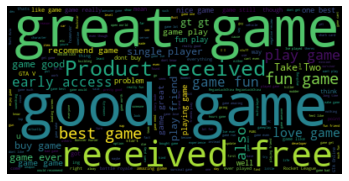

In [16]:
#Overall Sentiment WorldCloud
stopwords = set('stopwords')
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.reviewed)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [17]:
cloud_df = df[df['scores'] != 0]
cloud_df['sen_score'] = df['scores'].apply(lambda rating : +1 if rating > 0 else -1)
positive = cloud_df[cloud_df['sen_score'] == 1]
negative = cloud_df[cloud_df['sen_score'] ==-1]

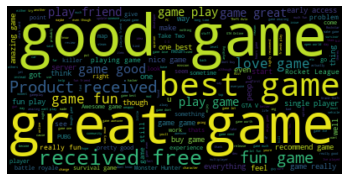

In [18]:
#Positive Sentiments Wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])

pos = " ".join(review for review in positive.reviewed)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
                  
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

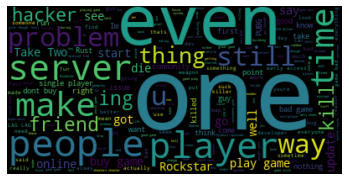

In [19]:
#Negative Sentiments Wordcloud
neg = " ".join(review for review in negative.reviewed)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)

plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

<AxesSubplot:xlabel='platforms', ylabel='name'>

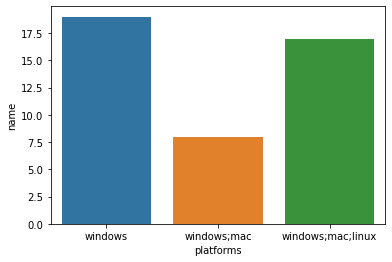

In [20]:
#Bar Chart for Games count based on Platform
graf12 = df[["name","platforms"]].groupby(['platforms'],as_index = False).nunique()
sns.barplot(data= graf12, x = 'platforms', y = 'name')

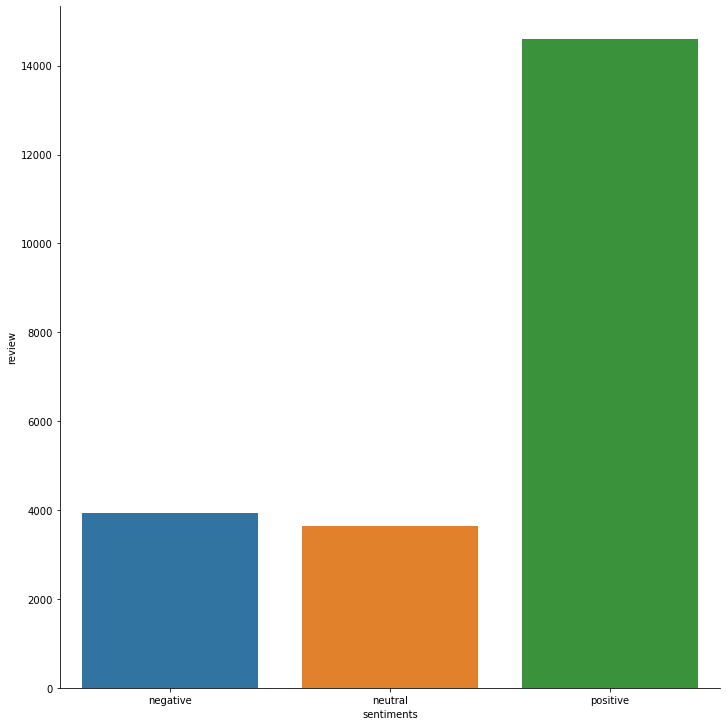

In [21]:
df_graf22 = df[["name","sentiments","review"]].groupby(['name','sentiments'],as_index = False).count()
graf42 = df_graf22[df_graf22['name'] == 'Dead by Daylight']
sns.catplot(x = "sentiments", y="review", kind="bar", data=graf42, height=10, aspect=1)

In [22]:
df_graf1 = df[["year","name","review"]].groupby(['year','name'],dropna=False,as_index=False).count()
graf2 = df[["name","year","hour_played"]].groupby(by=["name","year"],as_index=False,dropna=False).mean()
graf2 = graf2.sort_values(by = ['hour_played'])
graf2['year']= graf2.year.astype(int)
graf3 = df[["recommendation","name","review"]].groupby(['recommendation','name'],dropna=False,as_index=False).count()
graf4 = df[["genres","year","review"]].groupby(['genres','year'],dropna=False,as_index=False).count()
graf4['year']= graf4.year.astype(int)

In [25]:
#App Layout
app = Dash(__name__)

app.layout = html.Div([

    html.H1("Steam Game Data Statistics", style={'text-align': 'center'}),

html.Div([
    dcc.Dropdown(id='slct_game',
                 multi = False,
                 value = 'Grand Theft Auto V',
                 options = [{'label': x , 'value' : x } for x in df.name.unique()]),

    html.Br(),
    dcc.Graph(id = 'review_count', figure = {}),
    dcc.Graph(id = 'recommend', figure = {}),
    html.Br()
]),

html.Div([
    dcc.Slider(id='slct_year',
               min=2010,
               max=2019,
               dots=True,
               value=2015,
               marks={str(yr): str(yr) for yr in range(2010, 2019)}),

    html.Br(),
    dcc.Graph(id = 'avg_hour', figure = {}),
    dcc.Graph(id = 'genre_count', figure = {}),
    html.Br()
])
])

In [28]:
#Call Back
@app.callback(
    [Output(component_id='review_count', component_property='figure'),
     Output(component_id='avg_hour', component_property='figure'),
     Output(component_id='recommend', component_property='figure'),
     Output(component_id='genre_count', component_property='figure')],
    [Input(component_id='slct_game', component_property='value'),
     Input(component_id='slct_year', component_property='value')],
    prevent_initial_callback=False
)
def update_graph(option_slctd,option_slctd1):

    dff = df_graf1[df_graf1['name'] == option_slctd]

    fig = px.line(
        data_frame=dff,
        x='year',
        y='review',
        hover_data=['review'],
        template='plotly_dark',
        title="Review Count by Year")

    dff2 = graf3[graf3['name'] == option_slctd]

    fig2 = px.bar(
        data_frame=dff2,
        x='review',
        y='recommendation',
        hover_data=['review'],
        template='plotly_dark',
        title="Recommendation based on Games")

    dff1 = graf2[graf2['year'] == option_slctd1]

    fig1 = px.bar(
        data_frame=dff1,
        x='hour_played',
        y='name',
        hover_data=['hour_played'],
        template='plotly_dark',
        title="Average of Hour Played By Games")

    dff3 = graf4[graf4['year'] == option_slctd1]

    fig3 = px.pie(dff3,
        values='review',
        names='genres',
        title='Number of Reviews Based on Genres',
        template='plotly_dark')


    return fig,fig1,fig2,fig3,

In [ ]:
#run app
if __name__ == '__main__':
 app.run_server(debug=False)